# <center> <B>Cropping_images notebook</B></center>






In [1]:
!pip install chainercv

     |████████████████████████████████| 266kB 6.3MB/s 
  Created wheel for chainercv: filename=chainercv-0.13.1-cp36-cp36m-linux_x86_64.whl size=537359 sha256=42cf0ba26ba9bfc4502d00a4fd1501dbd3f475d02c45ea691ad2a5ea0fd20a43
  Stored in directory: /root/.cache/pip/wheels/ea/10/01/e221beaa4b3d8341aa819a39ab8d4677457c79c81f521f3a94
Successfully built chainercv


In [3]:
import matplotlib.pyplot as plt
from chainercv.datasets import voc_bbox_label_names
from chainercv.links import FasterRCNNVGG16,YOLOv3, YOLOv2
from chainercv.utils import read_image
from chainercv.visualizations import vis_bbox
from PIL import Image
import os

From: https://chainercv-models.preferred.jp/faster_rcnn_vgg16_voc07_trained_2018_06_01.npz
To: /root/.chainer/dataset/_dl_cache/0dac97e9e4e092363e01eb4f492b56ad
  %   Total    Recv       Speed  Time left
100  486MiB  486MiB   5959KiB/s    0:00:00

/usr/local/lib/python3.6/dist-packages/chainercv/utils/link.py:72: RuntimeWarning: Although the pretrained model is trained using cv2 as the backend of resize function, the current setting does not use cv2 as the backend of resize function. The performance may change due to using different backends. To suppress this warning, set `chainer.config.cv_resize_backend = "cv2".
  RuntimeWarning)


From: https://chainercv-models.preferred.jp/yolo_v3_voc0712_converted_2018_05_01.npz
To: /root/.chainer/dataset/_dl_cache/79d417010adfc0e1052bb8e5c4851753
  %   Total    Recv       Speed  Time left
 80  219MiB  175MiB   6017KiB/s    0:00:07Downloading ...
From: https://chainercv-models.preferred.jp/yolo_v2_voc0712_converted_2018_05_03.npz
To: /root/.chainer/dataset/_dl_cache/a8035a18ba140cc348cb620ce0d3ba73
  %   Total    Recv       Speed  Time left
100  179MiB  179MiB   5904KiB/s    0:00:00

# I - Define cropping methods

In [0]:
model0 = FasterRCNNVGG16(pretrained_model='voc07')
model1 = YOLOv3(pretrained_model='voc0712')
model2 = YOLOv2(pretrained_model='voc0712')

In [4]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
def save(bboxes,full_path):
    img = Image.open(full_path)
    top, left , bottom, right  = bboxes[0][0]
    cropped = img.crop( ( left, top, right, bottom) )  # size: 45, 45
    if 'cropped' not in  full_path:
        try:
            cropped.save(full_path[-4]+'_cropped.jpg', "JPEG", quality=80, optimize=True, progressive=True)
        except IOError:
            PIL.ImageFile.MAXBLOCK = cropped.size[0] * cropped.size[1]
            cropped.save(full_path[-4]+'_cropped.jpg', "JPEG", quality=80, optimize=True, progressive=True)

def compare_model(model, img):
    bboxes0, labels0, scores0 = model.predict([img])
    if len(bboxes0[0])>0:
        if labels0[0][0]==2:
            maximum_proba=scores0[0][0]
            return maximum_proba, bboxes0
    return(-1,-1)

def crop_test(path):
    for f in os.listdir(path):
        full_path = os.path.join(path, f)
        img = read_image(full_path)
        maximum0, bboxes_f0 = compare_model(model0, img)
        maximum1, bboxes_f1 = compare_model(model1, img)
        maximum2, bboxes_f2 = compare_model(model2, img)
        if max([maximum0 ,maximum1, maximum2])<=0.9:
            continue
        if maximum0==max([maximum0 ,maximum1, maximum2]):
            save(bboxes_f0,full_path)
            continue
        if maximum1==max([maximum1, maximum2]):
            save(bboxes_f1,full_path)
            continue
        if maximum2>max([maximum1, maximum2,maximum0]):
            save(bboxes_f2,full_path)
            continue

def crop_train_val(path_train_val):
    for root, dirs, files in os.walk(path_train_val):
        for file_name in files:
            full_path = os.path.join(path_train_val, dirs, file_name)
            img = read_image(full_path)
            maximum0, bboxes_f0 = compare_model(model0, img)
            maximum1, bboxes_f1 = compare_model(model1, img)
            maximum2, bboxes_f2 = compare_model(model2, img)

            if max([maximum0 ,maximum1, maximum2])<=0.9:
                continue

            if maximum0==max([maximum0 ,maximum1, maximum2]):
                save(bboxes_f0,full_path)
                continue

            if maximum1==max([maximum1, maximum2]):
                save(bboxes_f1,full_path)
                continue

            if maximum2>max([maximum1, maximum2,maximum0]):
                save(bboxes_f2,full_path)
                continue

# II - Test cropping methods

In [0]:
def plot(full_path,model):
    # Read an RGB image and return it in CHW format.
    img = read_image(full_path)
    bboxes, labels, scores = model.predict([img])
    print(labels, scores)
    vis_bbox(img, bboxes[0], labels[0], scores[0],
             label_names=voc_bbox_label_names)
    plt.show()

In [0]:
full_path1 = '/content/gdrive/My Drive/bird_dataset/test_images/mistery_category/0247efd7b9d47d036bb4390202a13e69.jpg'
full_path2 = '/content/gdrive/My Drive/bird_dataset/test_images/mistery_category/f4031c2fc6342ef8b328538d26782e0b.jpg'
full_path3 = '/content/gdrive/My Drive/bird_dataset/test_images/mistery_category/1a8bb12e211c86d35ac8105e74e616ee.jpg'
full_path4 = '/content/gdrive/My Drive/bird_dataset/test_images/mistery_category/85d53b3b764e317c7faacf3221ccc80c.jpg'


[array([2], dtype=int32)] [array([0.9989222], dtype=float32)]


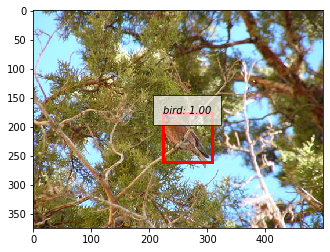

[array([2], dtype=int32)] [array([0.9977076], dtype=float32)]


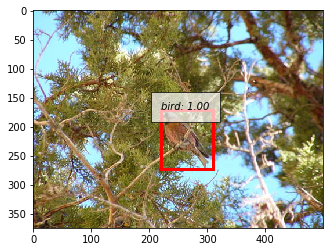

[array([2], dtype=int32)] [array([0.75858724], dtype=float32)]


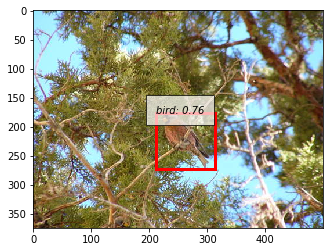

In [17]:
plot(full_path2,model0)
plot(full_path2,model1)
plot(full_path2,model2)

[array([2], dtype=int32)] [array([0.9835829], dtype=float32)]


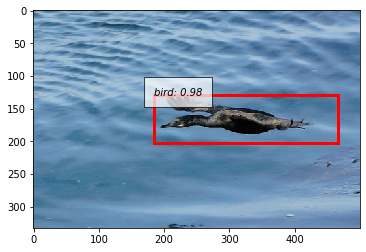

[array([2], dtype=int32)] [array([0.9925039], dtype=float32)]


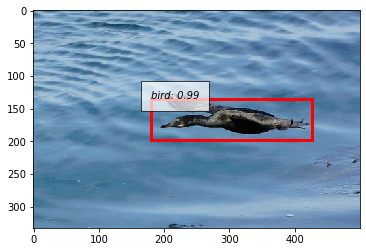

[array([2], dtype=int32)] [array([0.8177544], dtype=float32)]


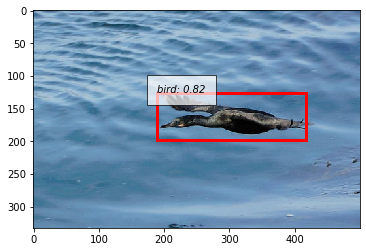

In [18]:
plot(full_path3,model0)
plot(full_path3,model1)
plot(full_path3,model2)

[array([], dtype=int32)] [array([], dtype=float32)]


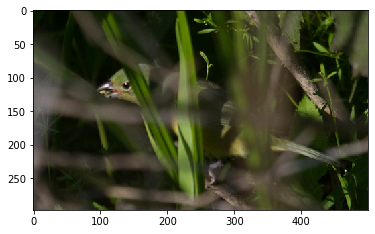

[array([], dtype=int32)] [array([], dtype=float32)]


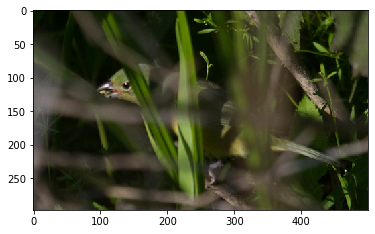

[array([15], dtype=int32)] [array([0.72878236], dtype=float32)]


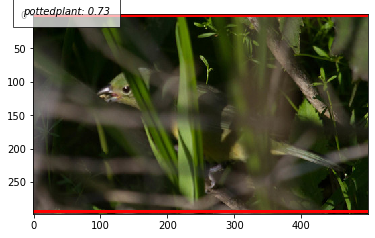

In [21]:
plot(full_path1,model0)
plot(full_path1,model1)
plot(full_path1,model2)


[array([2], dtype=int32)] [array([0.9655042], dtype=float32)]


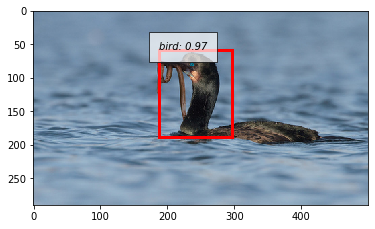

[array([2], dtype=int32)] [array([0.99962604], dtype=float32)]


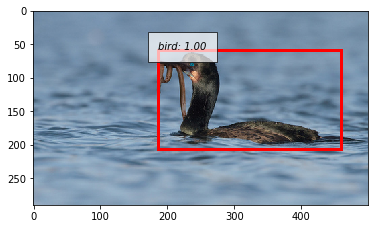

[array([2], dtype=int32)] [array([0.9019583], dtype=float32)]


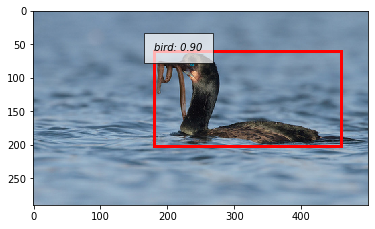

In [19]:
plot(full_path4,model0)
plot(full_path4,model1)
plot(full_path4,model2)

# III - Crop datasets : Test, Validation and Training

In [0]:
path_train='/content/gdrive/My Drive/train_images'
path_val='/content/gdrive/My Drive/val_images'
path_test='/content/gdrive/My Drive/bird_dataset/test_images/mistery_category'

In [0]:
cd '/content/gdrive/My Drive/bird_dataset/test_images/mistery_category'
crop_test(path_test)

In [0]:
cd '/content/gdrive/My Drive/bird_dataset/'
crop_train_val(path_train)
crop_train_val(path_test)